In [1]:
import numpy as np

from math import pi, sin, cos, sqrt, tanh

from siltsong import spherical_to_cartesian, plot_density_powernorm, radiative_transfer
from siltsong.dust import mrn, thermal_emission, henyey_greenstein
from siltsong.stars import blackbody

In [2]:
view_length = 32000
distance_steps = 200
theta_steps = 1
phi_steps = 1
distance_substeps = 10
dr = view_length / 2 / distance_steps
ds = dr / distance_substeps
dphi = pi / phi_steps

resolution = 201
depth = 201
depth_substeps = 10
dw = view_length / depth
ds_depth = dw / depth_substeps
grid_size = view_length / resolution

inclination_degrees = 60
inclination = pi * (inclination_degrees / 180)
sin_inc = sin(inclination)
cos_inc = cos(inclination)

ms_count = 1

wavelength = 5.47e-5

rho0_disk = 0.1
Rd = 2500 
zd = 300
rb = 500
rho0_bulge = 0.05

In [3]:
central_source = 0 # blackbody(wavelength, temperature = 1e8)
    
sca_cm_squared_per_g, ext_cm_squared_per_g = 0, 1.6e-15 # Assuming stars don't scatter light, so many suns in pc^2

source_function = (3.24 * 10 ** 19) ** 2 * blackbody(wavelength, temperature = 6000) # this outputs in cgs so I have to convert it to per pc^2

def scattering_phase_function(angle):
    return 0

In [4]:
def density_cartesian(x, y, z):
    
    R = np.sqrt(x ** 2 + y ** 2)
    disk_density = rho0_disk * np.exp(-R / Rd) * np.exp(-np.abs(z) / zd)
    r = np.sqrt(x ** 2 + y ** 2 + z ** 2)
    bulge_density = rho0_bulge / (1 + (r / rb) ** 2) ** (2.5)

    return disk_density + bulge_density

def density_spherical(r, theta):
    x, y, z = spherical_to_cartesian(r, theta, 0)
    return density_cartesian(x, y, z)

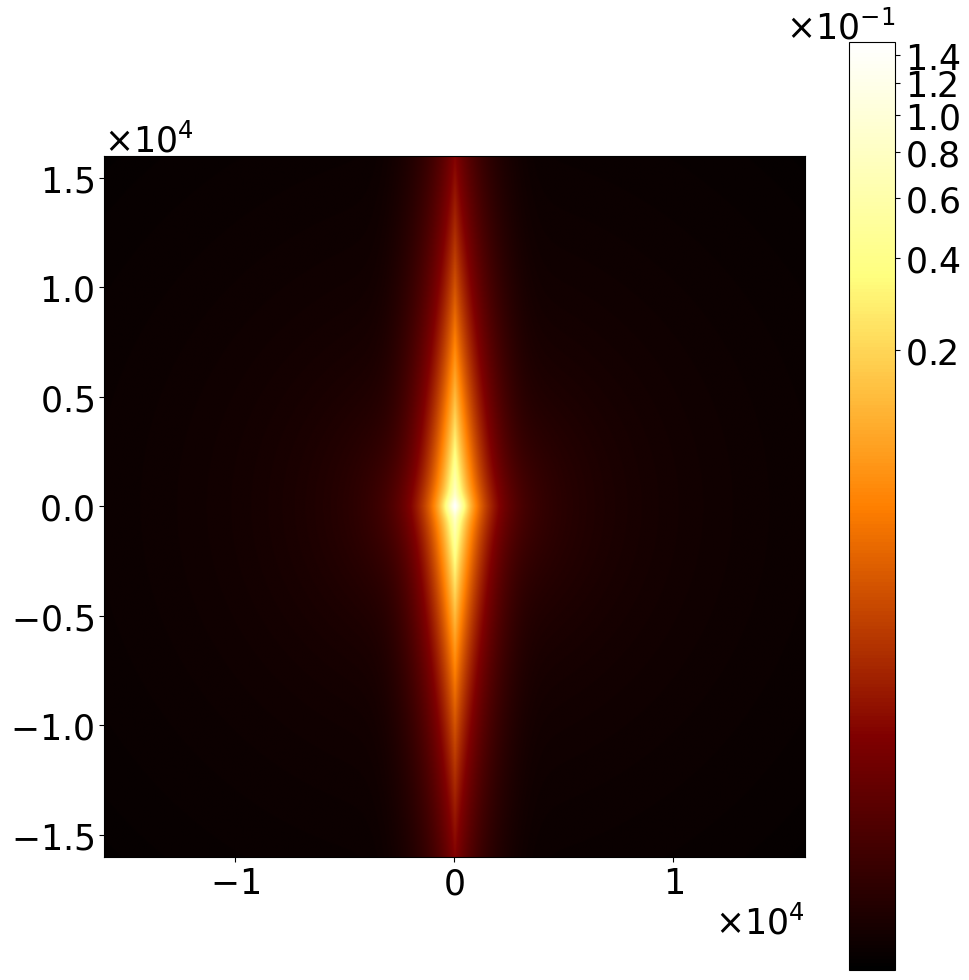

In [5]:
plot_density_powernorm(density_cartesian, view_length, power = 0.2, units = 'None') # sorry the distance and density units...

In [6]:
image = radiative_transfer(view_length, inclination_degrees, resolution, 
                           central_source, 
                           density_spherical, density_cartesian, 
                           sca_cm_squared_per_g, ext_cm_squared_per_g, source_function, scattering_phase_function, 
                           depth, depth_substeps, distance_steps, distance_substeps, theta_steps, phi_steps, 
                           ms_count)

Sending photons from the central source(s): 


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1259.17it/s]


Tracing multiple scattered photons: 


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 294.11it/s]


Performing peel-off: 


100%|█████████████████████████████████████████| 201/201 [01:23<00:00,  2.40it/s]


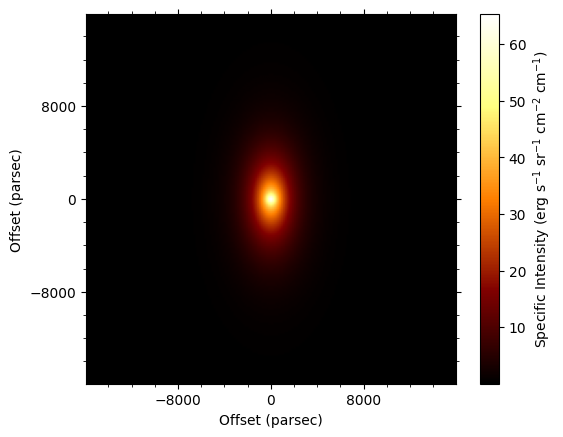

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator

pixel_size = view_length / resolution
n_pixels = image.shape[0]
half_size = (n_pixels // 2) * pixel_size
extent = [-half_size, half_size, -half_size, half_size]

plt.imshow(image / ((3.24 * 10 ** 19) ** 2), origin = 'lower', cmap = 'afmhot', extent = extent)

ax = plt.gca()
ax.set_aspect('equal')
ax.xaxis.set_major_locator(MultipleLocator(view_length // 4))
ax.xaxis.set_minor_locator(MultipleLocator(view_length // 16))
ax.yaxis.set_major_locator(MultipleLocator(view_length // 4))
ax.yaxis.set_minor_locator(MultipleLocator(view_length // 16))
ax.tick_params(which = 'both', direction = 'out', top = True, right = True)

ax.set_xlabel('Offset (parsec)')
ax.set_ylabel('Offset (parsec)')

cbar = plt.colorbar()
cbar.set_label(r'Specific Intensity (erg s$^{{-1}}$ sr$^{{-1}}$ cm$^{{-2}}$ cm$^{{-1}}$)')

plt.show()

In [8]:
# END